In [67]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt


accel = pd.read_csv("/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/Accelerometer.csv")
gyro = pd.read_csv("/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/Gyroscope.csv")
linAccel = pd.read_csv("/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/Linear Accelerometer.csv")

Hz = 50
times = np.array(list(range(1, int(max(gyro["Time (s)"].to_numpy())) * Hz))) / Hz # 100Hz

interpData = pd.DataFrame()

interpData["Time (s)"] = times
interpData["Gyro X (rad/s)"] = np.interp(times, gyro["Time (s)"], gyro["X (rad/s)"])
interpData["Gyro Y (rad/s)"] = np.interp(times, gyro["Time (s)"], gyro["Y (rad/s)"])
interpData["Gyro Z (rad/s)"] = np.interp(times, gyro["Time (s)"], gyro["Z (rad/s)"])
interpData["Accel X (m/s^2)"] = np.interp(times, accel["Time (s)"], accel["X (m/s^2)"])
interpData["Accel Y (m/s^2)"] = np.interp(times, accel["Time (s)"], accel["Y (m/s^2)"])
interpData["Accel Z (m/s^2)"] = np.interp(times, accel["Time (s)"], accel["Z (m/s^2)"])
interpData["Lin Accel X (m/s^2)"] = np.interp(times, linAccel["Time (s)"], linAccel["X (m/s^2)"])
interpData["Lin Accel Y (m/s^2)"] = np.interp(times, linAccel["Time (s)"], linAccel["Y (m/s^2)"])
interpData["Lin Accel Z (m/s^2)"] = np.interp(times, linAccel["Time (s)"], linAccel["Z (m/s^2)"])

maxTime = 42 * 60 * Hz
postureInterval = 2 * 60 * Hz
transTime = 10                           # Add 10 seconds needed to move to new position

# Remove data after experiment is done
interpData = interpData.drop(range(maxTime + transTime * Hz, len(interpData)))

# Label order of experiment
labelOrder = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'R', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']

# Set start times of transitions and labels, with 10 second time for transitions
transPos = [i for i in range(0, len(interpData), postureInterval)][:-1]
labelPos = [time + transTime * Hz for time in transPos]

# Set labels
labels = np.chararray(len(interpData), unicode = True)
for i, times in enumerate(zip(transPos, labelPos)):
    labels[times[0]:] = 'T'
    labels[times[1]:] = labelOrder[i]

interpData["Label"] = labels

# Lower size of data through change of data types
numVars = ["Gyro X (rad/s)", "Gyro Y (rad/s)", "Gyro Z (rad/s)", 
           "Accel X (m/s^2)", "Accel Y (m/s^2)", "Accel Z (m/s^2)",
           "Lin Accel X (m/s^2)", "Lin Accel Y (m/s^2)", "Lin Accel Z (m/s^2)"]
interpData[numVars] = interpData[numVars].astype(np.float32)

interpData["Time (s)"] = (interpData["Time (s)"] * 1000).astype(np.int32)
interpData = interpData.rename(columns = {"Time (s)": "Time (ms)"})

interpData["Label"] = interpData["Label"].astype('<U2')




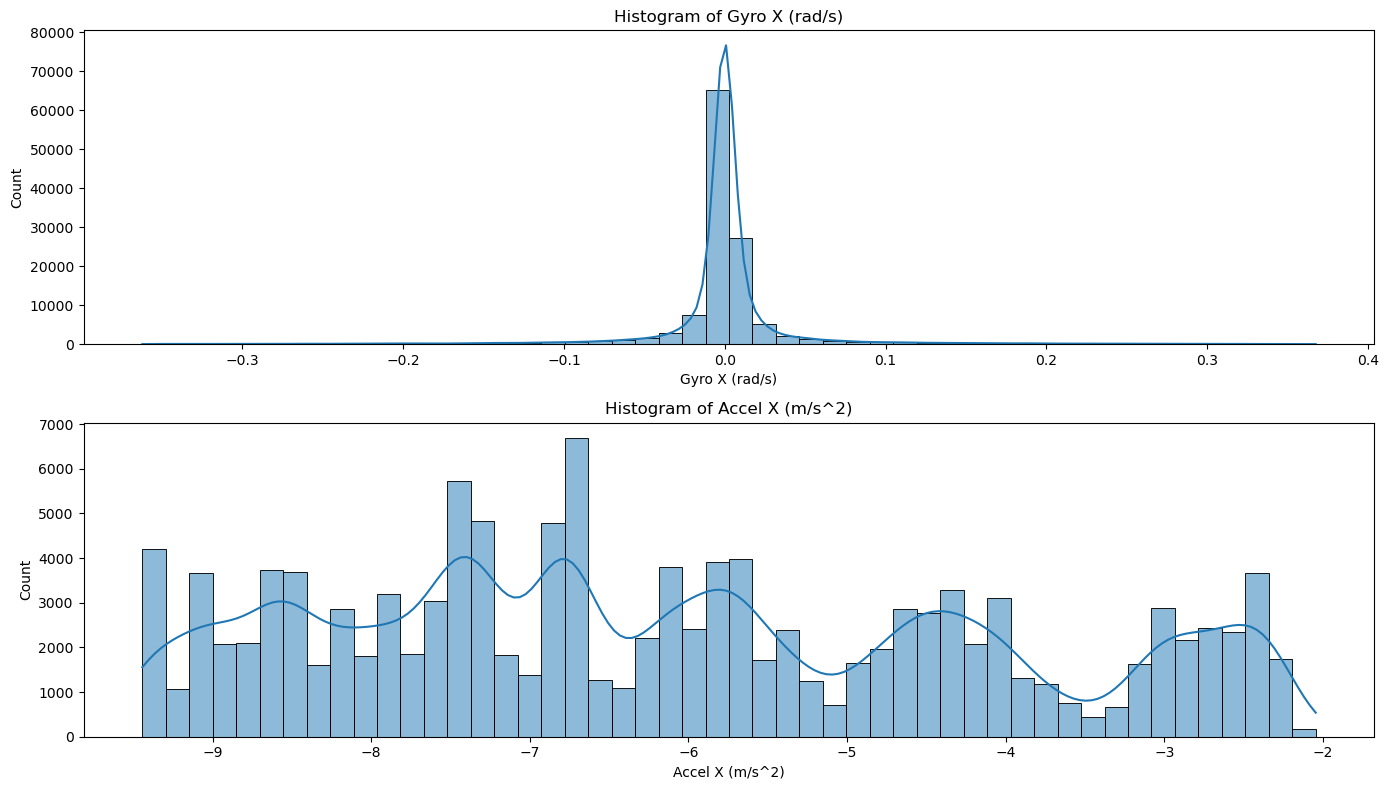

In [68]:
import pandas as pd
import seaborn as sns

# Calculate 1st and 99th percentile of "Gyro X (rad/s)"
q1_gyro = interpData["Gyro X (rad/s)"].quantile(0.01)
q99_gyro = interpData["Gyro X (rad/s)"].quantile(0.99)

# Limit the data to be between the 1st and 99th percentile
filtered_gyro = interpData[(interpData["Gyro X (rad/s)"] >= q1_gyro) & (interpData["Gyro X (rad/s)"] <= q99_gyro)]

# Calculate 1st and 99th percentile of "Accel X (m/s^2)"
q1_accel = interpData["Accel X (m/s^2)"].quantile(0.01)
q99_accel = interpData["Accel X (m/s^2)"].quantile(0.99)

# Limit the data to be between the 1st and 99th percentile
filtered_accel = interpData[(interpData["Accel X (m/s^2)"] >= q1_accel) & (interpData["Accel X (m/s^2)"] <= q99_accel)]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2)

bins = 50
# Create the first histogram with KDE
sns.histplot(data=filtered_gyro, x="Gyro X (rad/s)", bins=bins, kde=True, ax=axs[0])
axs[0].set_title('Histogram of Gyro X (rad/s)')

# Create the second histogram with KDE
sns.histplot(data=filtered_accel, x="Accel X (m/s^2)", bins=bins, kde=True, ax=axs[1])
axs[1].set_title('Histogram of Accel X (m/s^2)')

# change the size of the figure
fig.set_size_inches(14, 8)

# Display the plot
plt.tight_layout()
plt.show()

In [69]:
colors = np.zeros(len(interpData), dtype = "<U10")
colDict = {"T": "black", "R": "green", "L": "yellow", "B": "blue", "S": "red", "F": "turquoise"}

# Function to segment the data by continuous label
def segment_data(df):
    segments = []
    current_label = df.iloc[0]['Label']
    start_idx = 0
    for idx in range(1, len(df)):
        if df.iloc[idx]['Label'] != current_label:
            segments.append(df[start_idx:idx])
            start_idx = idx
            current_label = df.iloc[idx]['Label']
    segments.append(df[start_idx:])  # add the last segment
    return segments

# Segment the data
_interpData_in_min_time = interpData.copy(deep=True)
# _interpData_in_min_time = data.copy(deep=True).reset_index() # Run this after the data has been standardized
_interpData_in_min_time["Time (min)"] = _interpData_in_min_time["Time (ms)"] / 1000 / 60
_interpData_in_min_time.drop(columns=["Time (ms)"], inplace=True)
segments = segment_data(_interpData_in_min_time)

# Create the plot
fig = go.Figure()

# New order for labels
newLabOrder = []
for label in labelOrder:
    newLabOrder.append('T')
    newLabOrder.append(label)

# Add each segment as a separate trace
legend_added = set()
for i, segment in enumerate(segments):
    label = newLabOrder[i]
    show_legend = label not in legend_added
    fig.add_trace(go.Scatter(
        x = segment['Time (min)'],
        y = segment['Accel X (m/s^2)'],
        mode = 'lines',
        name = label,
        line = {
            "color": colDict[label]
        },
        showlegend = show_legend
    )),
    legend_added.add(label)

# Update layout
fig.update_layout(
    title = "Smartphone Accelerometer Time Series for Different Postures",
    xaxis_title = "Time (min)",
    yaxis_title = "Acceleration X (m/s^2)"
)
# update the size of the plot so it looks good on overleaf
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
)

# for i in range(0, maxTime + postureInterval, postureInterval):
#     fig.add_vline(x = i + transTime * Hz  , line_dash="dash")

# Show the plot
fig.show()

<Axes: title={'center': 'Accel X (m/s^2) before and after preprocessing - Lowpass Filter (cutoff=0.01, fs=1.0, order=5)'}, xlabel='Time (ms)'>

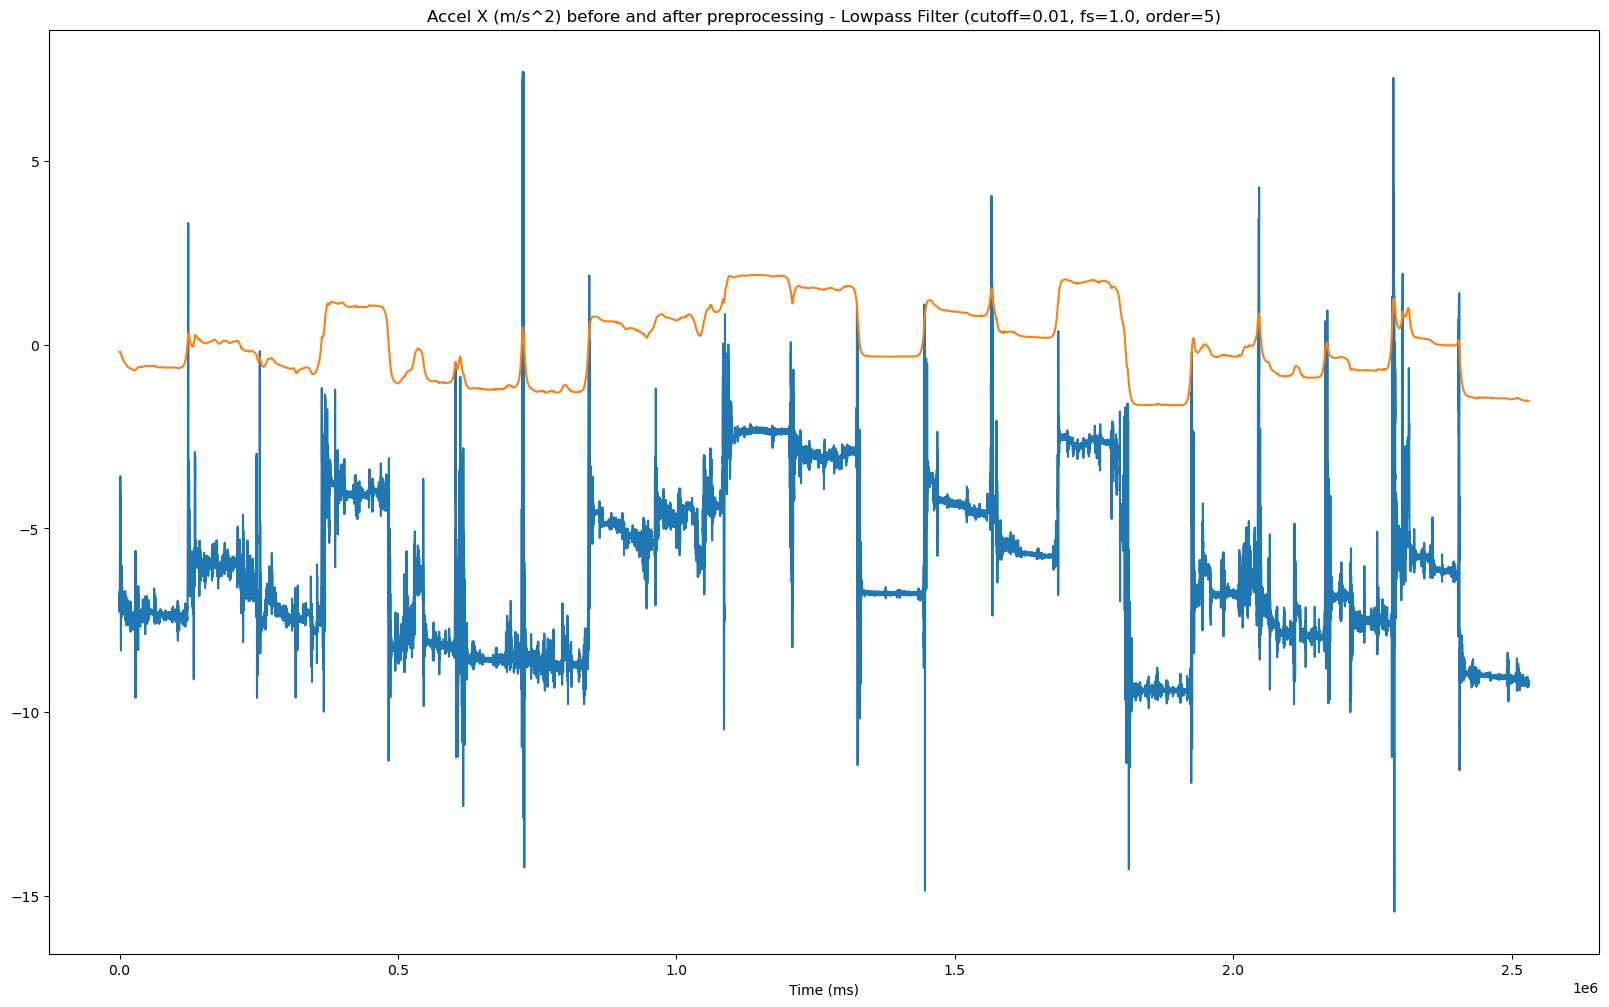

In [97]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter
import numpy as np
from tqdm import tqdm

from joblib import Parallel, delayed


class LowpassFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff=0.5, fs=1.0, order=5):
        self.cutoff = cutoff
        self.fs = fs
        self.order = order
    
    def lowpassFilter(self, data):
        nyq = 0.5 * self.fs
        normal_cutoff = self.cutoff / nyq
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_filtered = X.copy()
        for column in X_filtered.columns:
            X_filtered[column] = self.lowpassFilter(X_filtered[column])
        return X_filtered


class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.columns = None

    def fit(self, X, y=None):
        self.scaler.fit(X, y)
        self.columns = X.columns
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(self.scaler.transform(X), columns=self.columns)
    

class LOFOutlierMarker(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='kd_tree', n_neighbors=20):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y=None):
        self.lof = LocalOutlierFactor(algorithm='kd_tree', n_neighbors=self.n_neighbors)
        return self
    
    def transform(self, X, y=None):
        X_marked = X.copy()
        outliers = self.lof.fit_predict(X_marked) == -1
        X_marked[outliers] = np.nan
        return X_marked


class KalmanFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_jobs=-1):
        self.kf_dict = {}
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        self.kf_dict = {}
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_column)(X[col], col) for col in tqdm(X.columns)
        )
        self.kf_dict = {col: kf for col, kf in results}
        return self

    def _fit_column(self, data, col):
        kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])
        numpy_array_state = data.values.astype(np.float32)
        numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)
        kf = kf.em(numpy_matrix_state_with_mask, n_iter=5)
        return col, kf

    def transform(self, X):
        X = X.copy()
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._transform_column)(X[col], col) for col in tqdm(X.columns)
        )
        for col, new_data in results:
            X[col + '_kalman'] = new_data
        return X

    def _transform_column(self, data, col):
        numpy_array_state = data.values.astype(np.float32)
        numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)
        kf = self.kf_dict[col]
        new_data, _ = kf.filter(numpy_matrix_state_with_mask)
        return col, new_data
    
        
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

pipeline = Pipeline([
    ('lowpass_filter', LowpassFilterTransformer(cutoff=0.001, fs=1.0, order=1)),
    ('scaler', DataFrameStandardScaler()),
    ('lof_marker', LOFOutlierMarker(algorithm='kd_tree', n_neighbors=50)),
    # ('kalman_imputer', KalmanFilterTransformer())
])

data = interpData.copy(deep=True).set_index("Time (ms)")#.sample(frac=.1).sort_index()
ax = data['Accel X (m/s^2)'].plot(figsize=(20,12))

data_pre_processed = pipeline.fit_transform(X=data.drop(columns=["Label"]), y=data.Label)
data_pre_processed.index = data.index
data_pre_processed['Label'] = data['Label']
data_pre_processed['Accel X (m/s^2)'].plot(ax=ax, title="Accel X (m/s^2) before and after preprocessing - Lowpass Filter (cutoff=0.01, fs=1.0, order=5)")
# data_pre_processed['Accel X (m/s^2)_kalman'].plot(ax=ax)


Number of NaNs: 1220


100%|██████████| 126500/126500 [00:00<00:00, 3935757.41it/s]


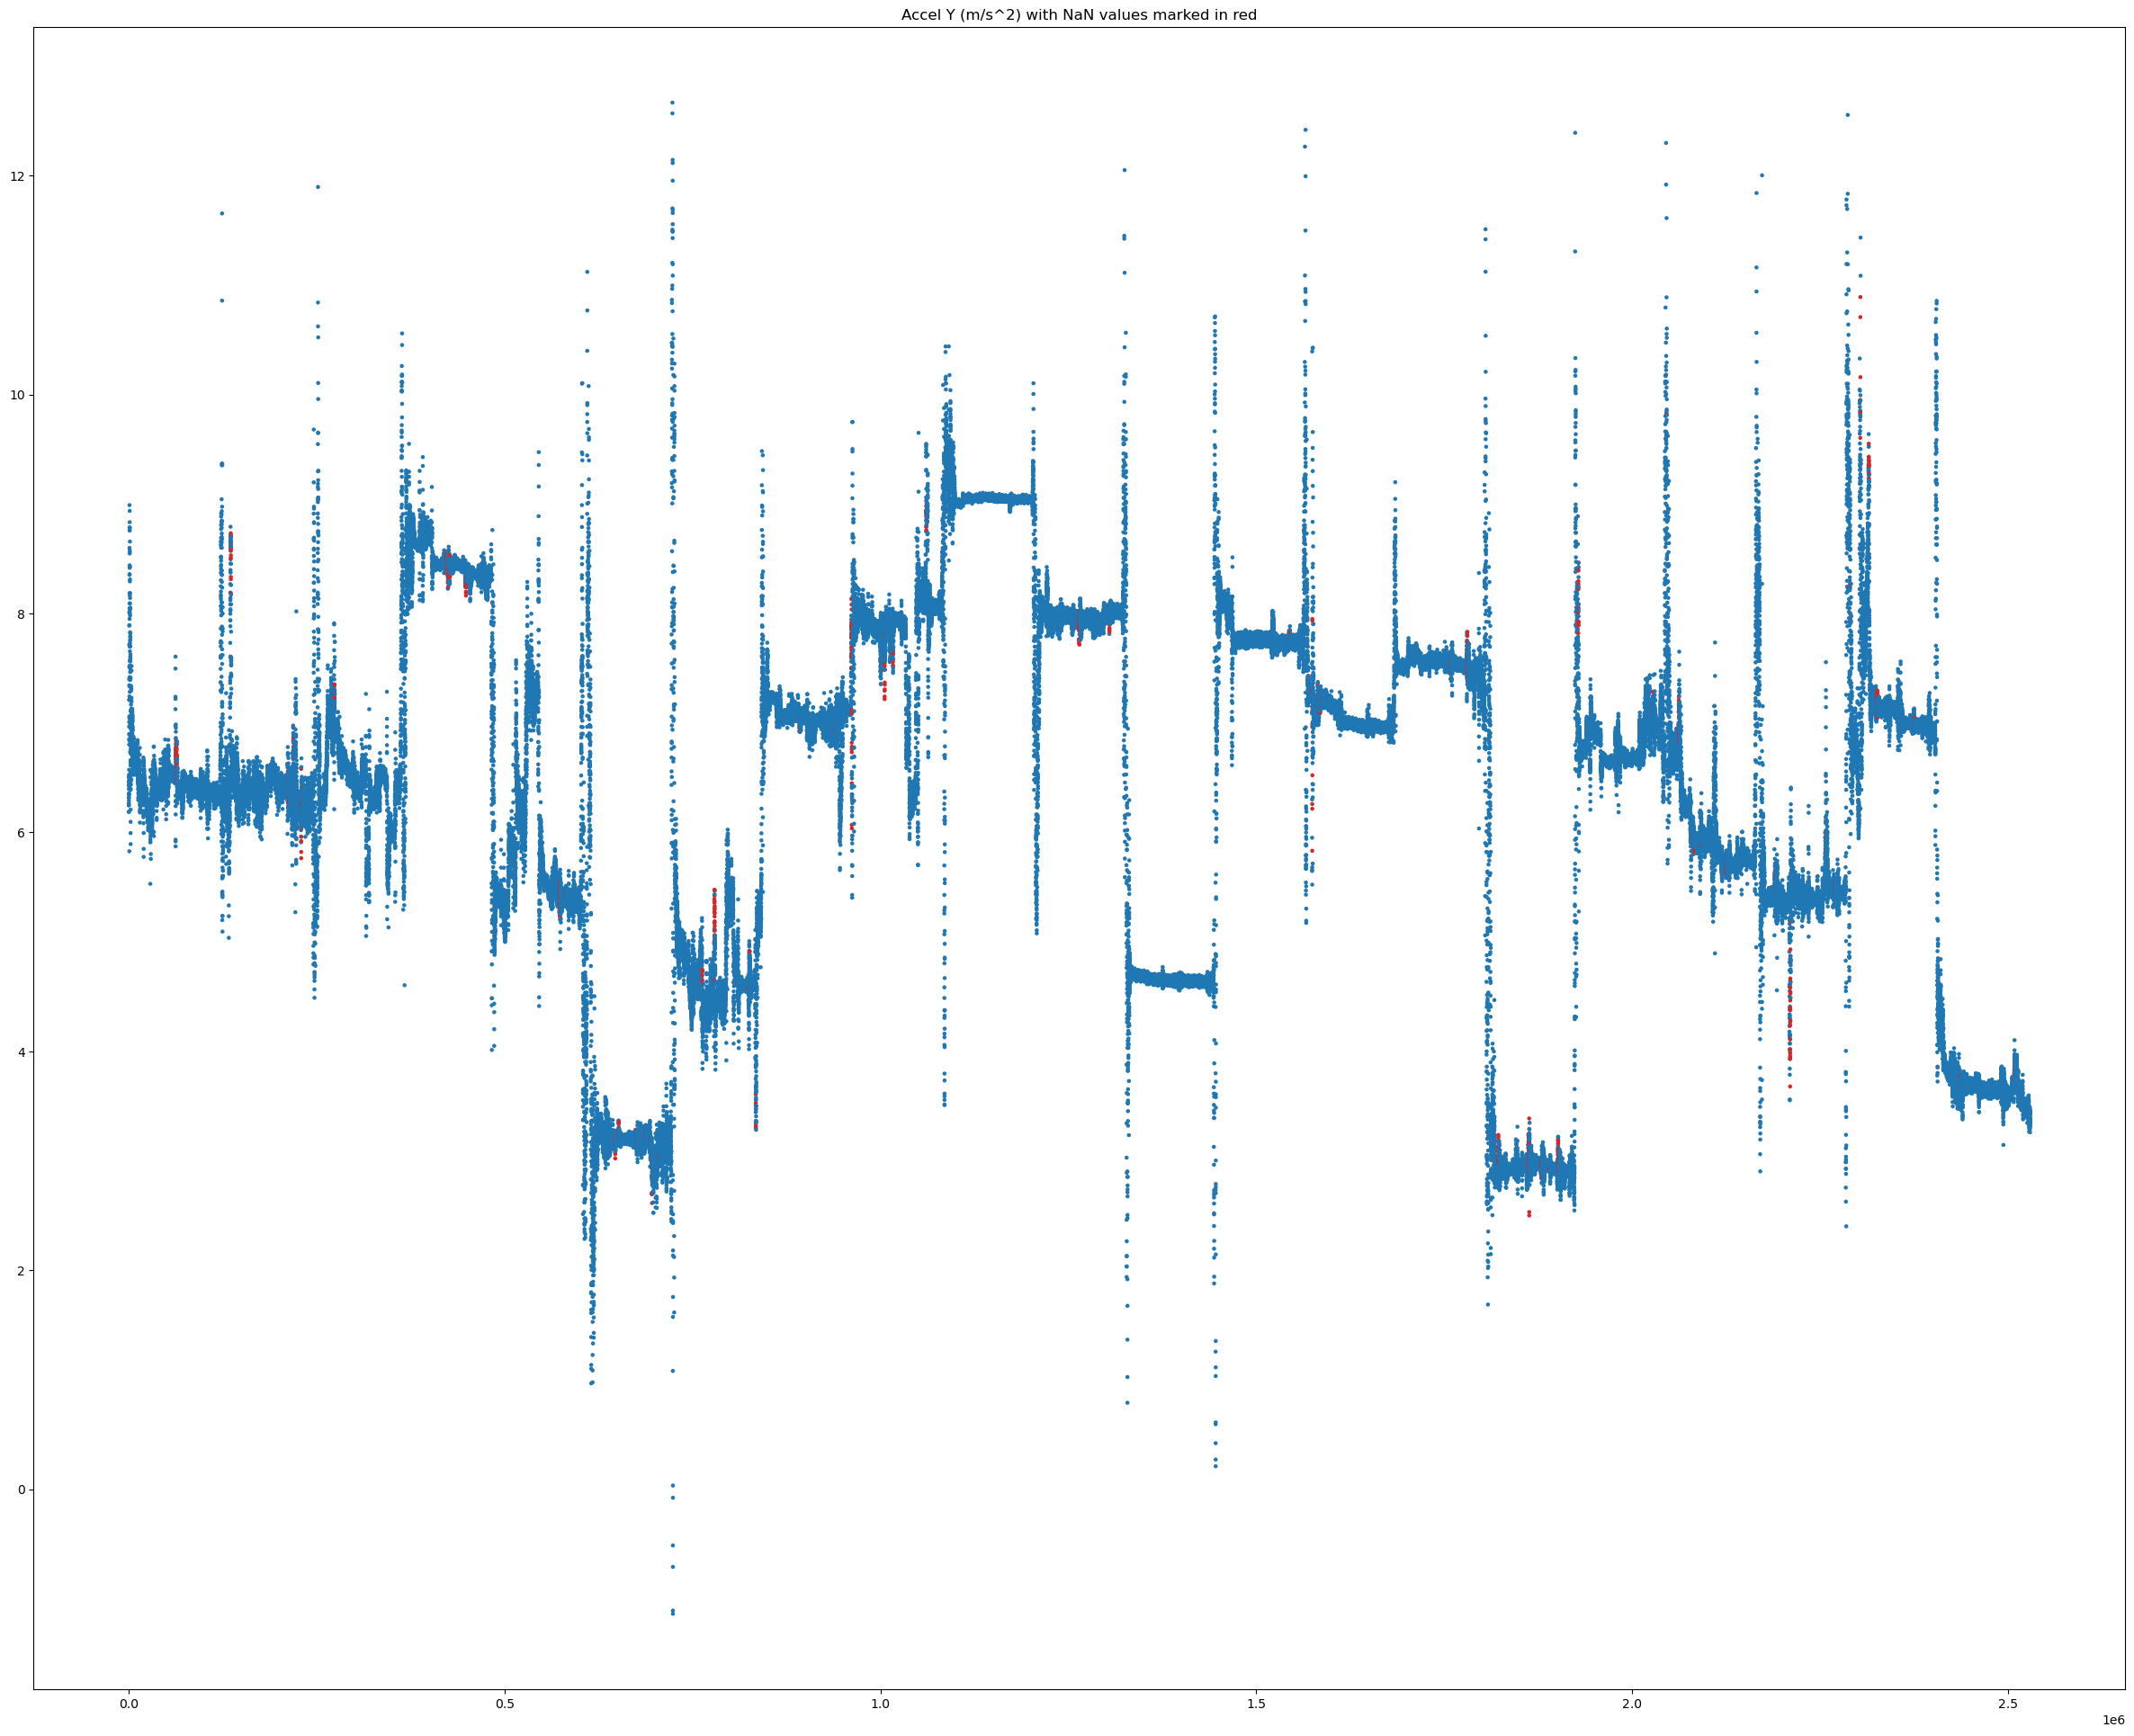

Gyro X (rad/s)         1220
Gyro Y (rad/s)         1220
Gyro Z (rad/s)         1220
Accel X (m/s^2)        1220
Accel Y (m/s^2)        1220
Accel Z (m/s^2)        1220
Lin Accel X (m/s^2)    1220
Lin Accel Y (m/s^2)    1220
Lin Accel Z (m/s^2)    1220
Label                     0
dtype: int64

In [98]:
from tqdm import tqdm, trange
c = []
column = 'Accel Y (m/s^2)'
_is_nan = data_pre_processed[[column]].isna().to_numpy()[:,0]
print(f'Number of NaNs: {_is_nan.sum()}')
for i in trange(data_pre_processed.shape[0]):
    if _is_nan[i]: 
        c.append('tab:red')
        # print(f'NaN at index {i}')
    else:       c.append('tab:blue')
    # break
# make a scatter plot matplotlib
plt.figure(figsize=(30,24))
plt.scatter(data.index, data[column], c=c, s=5)
plt.title(f'{column} with NaN values marked in red')
plt.show()

# give me the nan values in the data_pre_processed
data_pre_processed.isna().sum()

NameError: name 'data_pre_processed' is not defined

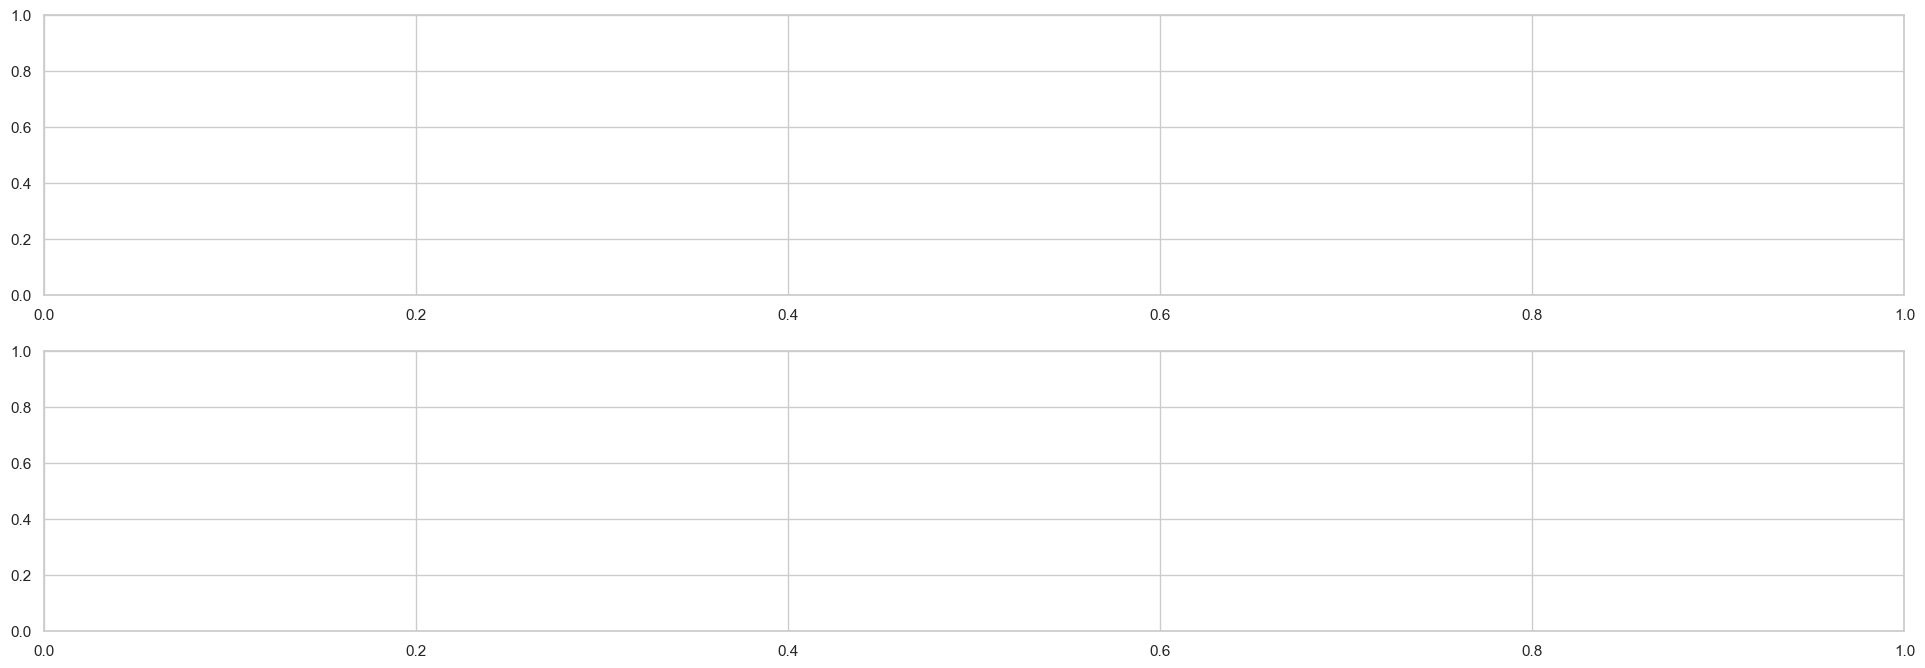

In [23]:
# Create the plot with 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 8))

# First subplot
ax = data_pre_processed['Accel X (m/s^2)'].plot(ax=axes[0], label='Accel X (m/s^2)')
data_pre_processed['Accel X (m/s^2)_kalman'].plot(ax=ax, label='Accel X (m/s^2)_kalman')
axes[0].legend()
axes[0].set_title('Accel X (m/s^2) and Accel X (m/s^2)_kalman')

# Second subplot
(data_pre_processed['Accel X (m/s^2)'] - data_pre_processed['Accel X (m/s^2)_kalman']).plot(ax=axes[1])
axes[1].set_title('Difference between Accel X (m/s^2) and Accel X (m/s^2)_kalman')

plt.show()

----------------------------------
# **Prediction - Flaml** 

In [15]:
# give me the nan values in the data_pre_processed
data_pre_processed.isna().sum()

Gyro X (rad/s)         253000
Gyro Y (rad/s)         253000
Gyro Z (rad/s)         253000
Accel X (m/s^2)        253000
Accel Y (m/s^2)        253000
Accel Z (m/s^2)        253000
Lin Accel X (m/s^2)    253000
Lin Accel Y (m/s^2)    253000
Lin Accel Z (m/s^2)    253000
Label                       0
dtype: int64

In [6]:
# Importing the necessary libraries for the task
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

_data = data.copy(deep=True)
_data = data_pre_processed.copy(deep=True)

X = _data.drop(columns=['Label'])
y = _data['Label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize AutoML
automl = AutoML()

# Define the settings for FLAML
settings = {
    "time_budget": 10*60,  # time budget in seconds
    "metric": 'accuracy',  # primary metric to optimize
    "task": 'classification',  # type of task
    "log_file_name": 'flaml.log',  # flaml log file
    "estimator_list": ['lgbm'],  # list of estimators
    "eval_method": 'cv',  # cross-validation method
    "n_splits": 5,  # number of folds for cross-validation

    # skip preprocessing
    "skip_transform": True
}

# Train the model
automl.fit(X_train, y_train, **settings)

# Get predictions
y_pred = automl.predict(X_test)

[flaml.automl.logger: 06-09 16:33:33] {1680} INFO - task = classification
[flaml.automl.logger: 06-09 16:33:33] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-09 16:33:33] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-09 16:33:33] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 06-09 16:33:33] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-09 16:33:35] {2345} INFO - Estimated sufficient time budget=21506s. Estimated necessary time budget=22s.
[flaml.automl.logger: 06-09 16:33:35] {2392} INFO -  at 2.3s,	estimator lgbm's best error=0.2005,	best estimator lgbm's best error=0.2005
[flaml.automl.logger: 06-09 16:33:35] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-09 16:33:37] {2392} INFO -  at 4.1s,	estimator lgbm's best error=0.2005,	best estimator lgbm's best error=0.2005
[flaml.automl.logger: 06-09 16:33:37] {2219} INFO - iteration 2, current learner lgbm
[fla

In [7]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score       support
B              0.999775  0.999888  0.999832   8904.000000
F              0.999775  0.999663  0.999719   8899.000000
L              0.999730  1.000000  0.999865  11109.000000
R              0.999657  1.000000  0.999828   8738.000000
S              0.999886  0.999886  0.999886   8758.000000
T              0.998806  0.997376  0.998090   4192.000000
accuracy       0.999684  0.999684  0.999684      0.999684
macro avg      0.999605  0.999469  0.999537  50600.000000
weighted avg   0.999684  0.999684  0.999684  50600.000000

In [8]:
_data = data.copy(deep=True)

X = _data.drop(columns=['Label'])
y = _data['Label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize AutoML
automl = AutoML()

# Define the settings for FLAML
settings = {
    "time_budget": 10*60,  # time budget in seconds
    "metric": 'accuracy',  # primary metric to optimize
    "task": 'classification',  # type of task
    "log_file_name": 'flaml.log',  # flaml log file
    "estimator_list": ['lgbm'],  # list of estimators
    "eval_method": 'cv',  # cross-validation method
    "n_splits": 5,  # number of folds for cross-validation

    # skip preprocessing
    "skip_transform": True,

    "n_jobs": -1
}

# Train the model
automl.fit(X_train, y_train, **settings)

# Get predictions
y_pred = automl.predict(X_test)

[flaml.automl.logger: 06-09 16:43:18] {1680} INFO - task = classification
[flaml.automl.logger: 06-09 16:43:18] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-09 16:43:18] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-09 16:43:18] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 06-09 16:43:18] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-09 16:43:19] {2345} INFO - Estimated sufficient time budget=12671s. Estimated necessary time budget=13s.
[flaml.automl.logger: 06-09 16:43:19] {2392} INFO -  at 1.4s,	estimator lgbm's best error=0.1767,	best estimator lgbm's best error=0.1767
[flaml.automl.logger: 06-09 16:43:19] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-09 16:43:21] {2392} INFO -  at 2.7s,	estimator lgbm's best error=0.1767,	best estimator lgbm's best error=0.1767
[flaml.automl.logger: 06-09 16:43:21] {2219} INFO - iteration 2, current learner lgbm
[fla

In [9]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score       support
B              0.984074  0.992363  0.988201   8904.000000
F              0.983034  0.989662  0.986337   8899.000000
L              0.986679  0.993429  0.990042  11109.000000
R              0.979094  0.991531  0.985273   8738.000000
S              0.981435  0.977849  0.979639   8758.000000
T              0.934649  0.869990  0.901161   4192.000000
accuracy       0.979328  0.979328  0.979328      0.979328
macro avg      0.974827  0.969137  0.971775  50600.000000
weighted avg   0.979051  0.979328  0.979079  50600.000000